# Image Preprocessing
We normalize the brightness values and resize the images to a standard shape

In [1]:
%matplotlib inline

from glob import glob
from ipywidgets import FloatProgress
from IPython.display import display
import os
import pickle
import re
import warnings

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageOps
import seaborn as sns

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

SIZE = 224  # for ImageNet models compatibility

In [2]:
def natural_key(string_):
    """
    Define sort key that is integer-aware
    """
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

In [3]:
def norm_image(img):
    """
    Normalize PIL image
    
    Normalizes each color channel to (mean,std)=(0,1), and applies a [1%, 99%] contrast stretch
    """
    # Convert to a NumPy array
    # The array will be transposed, but it doesn't matter, so we leave it
    img_nrm = np.asarray(img).astype(float)
    rows, cols, clrs = img_nrm.shape

    # Normalize the image to [0,1]
    for clr in range(clrs):
        img_p = img_nrm[..., clr] / 255
        img_p -= img_p.mean()
        img_p /= img_p.std()
        scale = np.max([np.abs(np.percentile(img_p, 1.0)),
                        np.abs(np.percentile(img_p, 99.0))])
        img_p = img_p / scale
        img_p = np.clip(img_p, -1.0, 1.0)
        img_p = (img_p + 1.0) / 2.0
        img_nrm[..., clr] = img_p

    # Convert back to PIL image
    img_nrm = (img_nrm * 255 + 0.5).astype(np.uint8)

    return Image.fromarray(img_nrm)

In [4]:
def resize_image(img, size):
    """
    Resize PIL image
    
    Resizes image to be square with sidelength size. Pads with black if needed.
    """
    # Resize
    n_x, n_y = img.size
    if n_y > n_x:
        n_y_new = SIZE
        n_x_new = int(SIZE * n_x / n_y + 0.5)
    else:
        n_x_new = SIZE
        n_y_new = int(SIZE * n_y / n_x + 0.5)

    img_res = img.resize((n_x_new, n_y_new), resample=PIL.Image.BICUBIC)

    # Pad the borders to create a square image
    img_pad = Image.new('RGB', (SIZE, SIZE), (0, 0, 0))
    ulc = ((SIZE - n_x_new) // 2, (SIZE - n_y_new) // 2)
    img_pad.paste(img_res, ulc)

    return img_pad

In [5]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

train_cats = sorted(glob(os.path.join(TRAIN_DIR, 'cat*.jpg')), key=natural_key)
train_dogs = sorted(glob(os.path.join(TRAIN_DIR, 'dog*.jpg')), key=natural_key)
train_all = train_cats + train_dogs

test_all = sorted(glob(os.path.join(TEST_DIR, '*.jpg')), key=natural_key)

24486


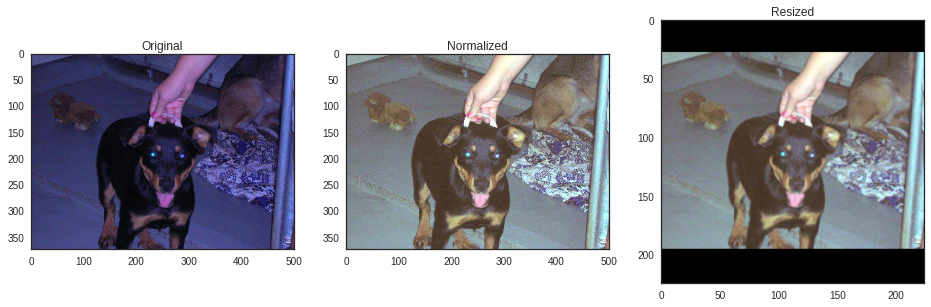

In [6]:
# Read the image
idx = np.random.randint(0, len(train_all))
print(idx)
path = train_all[idx]
# img_pil = Image.open(path)
img = Image.open(path)
# img = np.asarray(img_pil)

# Normalize it
img_nrm = norm_image(img)

# Resize it
img_res = resize_image(img_nrm, SIZE)

# Show it
with sns.axes_style("white"):
    plt.figure(figsize=(16,8))
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(img)

    plt.subplot(132)
    plt.title('Normalized')
    plt.imshow(img_nrm)

    plt.subplot(133)
    plt.title('Resized')
    plt.imshow(img_res)